In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import RidgeCV
from sklearn.impute import SimpleImputer


In [89]:
selected_features =  ['SUM(transactions.Revenue)', 'SUM(transactions.Quantity)', 'COUNT(transactions) + MAX(transactions.Quantity)', 'total_orders', 'COUNT(transactions) + MAX(transactions.Revenue)', 'COUNT(transactions)', 'purchase_frequency', 'active_days', 'avg_days_between_orders', 'avg_items_per_order', 'avg_order_value', 'MAX(transactions.Revenue)', 'MEAN(transactions.Revenue)', 'MAX(transactions.Quantity) + MEAN(transactions.Revenue)']
train = pd.read_csv('../data/features/train_final.csv')
val = pd.read_csv('../data/features/val_final.csv')
test = pd.read_csv('../data/features/test_final.csv')

y_train = train['CLV_Target']
X_train = train[selected_features]

y_val = val['CLV_Target']
X_val = val[selected_features]

y_test = test['CLV_Target']
X_test = test[selected_features]

In [91]:
print(train['CLV_Target'].mean())
print(val['CLV_Target'].mean())
print(test['CLV_Target'].mean())

725.830945018226
555.3373484566754
565.1288473346358


In [87]:
val.columns

Index(['CustomerID', 'days_since_last_purchase', 'customer_age_days',
       'active_days', 'total_orders', 'purchase_frequency',
       'avg_items_per_order', 'avg_days_between_orders', 'avg_order_value',
       'avg_item_value', 'COUNT(transactions)', 'MAX(transactions.Quantity)',
       'MAX(transactions.Revenue)', 'MAX(transactions.UnitPrice)',
       'MEAN(transactions.Quantity)', 'MEAN(transactions.Revenue)',
       'MEAN(transactions.UnitPrice)', 'MIN(transactions.Quantity)',
       'MIN(transactions.Revenue)', 'MIN(transactions.UnitPrice)',
       'SUM(transactions.Quantity)', 'SUM(transactions.Revenue)',
       'COUNT(transactions) + MAX(transactions.Quantity)',
       'COUNT(transactions) + MAX(transactions.Revenue)',
       'MAX(transactions.Quantity) + MEAN(transactions.Revenue)',
       'MAX(transactions.UnitPrice) + MIN(transactions.Quantity)',
       'MEAN(transactions.UnitPrice) + MIN(transactions.UnitPrice)',
       'CLV_Target'],
      dtype='object')

# Ridge Regression
- To start the modeling process I will train a ridge regression using cross validation - this will act as the baseline model to compare our ensembled methods against

In [93]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, selected_features)
    ]
)
pipeline_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5))
])

pipeline_ridge.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
y_val_pred_ridge = pipeline_ridge.predict(X_val)

ridge_train_rsme = np.sqrt(mean_squared_error(y_train, pipeline_ridge.predict(X_train)))
print(f'Ridge Training RMSE: {ridge_train_rsme:.4f}')
ridge_val_rsme = np.sqrt(mean_squared_error(y_val, y_val_pred_ridge))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_ridge))
val_r2 = pipeline_ridge.score(X_val, y_val)
val_mae = mean_absolute_error(y_val, y_val_pred_ridge)
print(f'Ridge Validation R2: {val_r2:.4f}')
print(f'Ridge Validation MAE: {val_mae:.4f}')

print(f'Ridge Validation RMSE: {ridge_val_rsme:.4f}')

best_ridge = pipeline_ridge

Ridge Training RMSE: 1516.4330
Ridge Validation R2: 0.7664
Ridge Validation MAE: 451.1351
Ridge Validation RMSE: 1269.2618


### Next we will repeat the above but using MLflow to track and log models

In [7]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import json

In [9]:
# Set experiment name (organizes related runs)
mlflow.set_experiment("CLV_Baseline_Models")

# Start MLflow run
with mlflow.start_run(run_name="Ridge_Baseline"):
    
    # Log model parameters
    mlflow.log_param("model_type", "ridge")
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("alphas", "[0.1, 1.0, 10.0]")
    mlflow.log_param("imputer_strategy", "median")
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("n_features", len(selected_features))
    
    # Log dataset info
    mlflow.log_params({
        "train_samples": len(X_train),
        "val_samples": len(X_val),
    })
    
    # Retraining the model
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, selected_features)
        ]
    )
    
    pipeline_ridge = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RidgeCV(alphas=[0.1, 1.0, 10.0, 15], cv=5))
    ])
    
    # Fit model
    pipeline_ridge.fit(X_train, y_train)
    
    # Log best alpha
    best_alpha = pipeline_ridge.named_steps['model'].alpha_
    mlflow.log_param("best_alpha", best_alpha)
    
    # Get predictions
    y_train_pred = pipeline_ridge.predict(X_train)
    y_val_pred = pipeline_ridge.predict(X_val)
    
    # Evaluate metrics
    # Training metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Validation metrics
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Overfitting metrics
    rmse_gap = val_rmse - train_rmse
    r2_gap = train_r2 - val_r2
    
    # Log metrics
    mlflow.log_metrics({
        "train_rmse": train_rmse,
        "train_mae": train_mae,
        "train_r2": train_r2,
        "val_rmse": val_rmse,
        "val_mae": val_mae,
        "val_r2": val_r2,
        "rmse_gap": rmse_gap,
        "r2_gap": r2_gap
    })
    
    # Log features used
    feature_dict = {
        "selected_features": selected_features,
        "n_features": len(selected_features),
        "feature_selection_method": "voting_ensemble"
    }
    mlflow.log_dict(feature_dict, "selected_features.json")
    
    # Log the model
    # Create signature (defines input/output schema)
    signature = infer_signature(X_train[selected_features], y_train_pred)
    
    mlflow.sklearn.log_model(
        pipeline_ridge,
        "ridge_model",
        signature=signature,
        input_example=X_train[selected_features].iloc[:5]  # Log sample input
    )
    
    # Add tags
    mlflow.set_tags({
        "stage": "baseline",
        "model_family": "linear",
        "feature_selection": "completed",
        "author": "Bread"
    })
    
    # Print results
    print(f"Ridge Training RMSE: {train_rmse:.4f}")
    print(f"Ridge Validation RMSE: {val_rmse:.4f}")
    print(f"Ridge Validation R²: {val_r2:.4f}")
    print(f"Best Alpha: {best_alpha}")
    print(f"\nMLflow Run ID: {mlflow.active_run().info.run_id}")

/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/16 12:58:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Ridge Training RMSE: 1516.4330
Ridge Validation RMSE: 1269.2618
Ridge Validation R²: 0.7664
Best Alpha: 10.0

MLflow Run ID: ef49639c0c3b4a19bb573e012da8e2bf


# Polynomial Regression:

In [56]:
from sklearn.preprocessing import PolynomialFeatures
from mlflow.models import infer_signature
import matplotlib.pyplot as plt


# ========== SET EXPERIMENT ==========
mlflow.set_experiment("CLV_Baseline_Models")

# ========== START RUN ==========
with mlflow.start_run(run_name="Ridge_PolynomialFeatures"):
    
    print("="*70)
    print("TRAINING RIDGE WITH POLYNOMIAL FEATURES")
    print("="*70)
    
    # ========== LOG PARAMETERS ==========
    poly_degree = 2
    alphas = [0.1, 1.0, 10.0, 15.0]
    
    mlflow.log_params({
        "model_type": "ridge_polynomial",
        "poly_degree": poly_degree,
        "include_bias": False,
        "alphas": str(alphas),
        "cv_folds": 5,
        "imputer_strategy": "median",
        "scaler": "StandardScaler",
        "n_original_features": len(selected_features),
        "train_samples": len(X_train),
        "val_samples": len(X_val)
    })
    
    # ========== BUILD PIPELINE ==========
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('poly_features', PolynomialFeatures(degree=poly_degree, include_bias=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, selected_features)
        ]
    )
    
    pipeline_ridge = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RidgeCV(alphas=alphas, cv=5))
    ])
    
    # ========== TRAIN MODEL ==========
    print("\nTraining model...")
    start_time = time.time()
    
    pipeline_ridge.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    mlflow.log_metric("training_time_seconds", training_time)
    
    best_poly_ridge = pipeline_ridge
    # ========== LOG BEST ALPHA ==========
    best_alpha = pipeline_ridge.named_steps['model'].alpha_
    mlflow.log_param("best_alpha", best_alpha)
    
    # Calculate number of polynomial features created
    poly_transformer = pipeline_ridge.named_steps['preprocessor'].named_transformers_['num'].named_steps['poly_features']
    n_poly_features = poly_transformer.n_output_features_
    mlflow.log_param("n_poly_features", n_poly_features)
    
    print(f"Created {n_poly_features} polynomial features from {len(selected_features)} original features")
    print(f"Best alpha: {best_alpha}")
    
    # ========== PREDICTIONS ==========
    y_train_pred = pipeline_ridge.predict(X_train)
    y_val_pred = pipeline_ridge.predict(X_val)
    
    # ========== CALCULATE METRICS ==========
    # Training metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Validation metrics
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Overfitting metrics
    rmse_gap = val_rmse - train_rmse
    r2_gap = train_r2 - val_r2
    rmse_ratio = val_rmse / train_rmse
    
    # ========== LOG ALL METRICS ==========
    mlflow.log_metrics({
        "train_rmse": train_rmse,
        "train_mae": train_mae,
        "train_r2": train_r2,
        "val_rmse": val_rmse,
        "val_mae": val_mae,
        "val_r2": val_r2,
        "rmse_gap": rmse_gap,
        "r2_gap": r2_gap,
        "rmse_ratio": rmse_ratio
    })
    
    # ========== LOG MODEL ==========
    signature = infer_signature(X_train[selected_features], y_train_pred)
    
    mlflow.sklearn.log_model(
        pipeline_ridge,
        "ridge_poly_model",
        signature=signature,
        input_example=X_train[selected_features].iloc[:5]
    )
    
    # ========== LOG FEATURE NAMES ==========
    # Get polynomial feature names
    poly_feature_names = poly_transformer.get_feature_names_out(selected_features)
    mlflow.log_dict({
        "original_features": selected_features,
        "poly_feature_names": poly_feature_names.tolist()[:100]  # Log first 100 to avoid huge file
    }, "feature_names.json")
    
    # ========== LOG COEFFICIENTS ==========
    coefficients = pipeline_ridge.named_steps['model'].coef_
    
    # Get top 20 coefficients by absolute value
    coef_df = pd.DataFrame({
        'feature': poly_feature_names,
        'coefficient': coefficients
    })
    coef_df['abs_coefficient'] = coef_df['coefficient'].abs()
    top_coefs = coef_df.nlargest(20, 'abs_coefficient')
    
    top_coefs.to_csv('top_coefficients.csv', index=False)
    mlflow.log_artifact('top_coefficients.csv')
    
    # ========== VISUALIZATIONS ==========
    
    # 1. Top Coefficients Plot
    plt.figure(figsize=(12, 8))
    colors = ['red' if x < 0 else 'green' for x in top_coefs['coefficient']]
    plt.barh(range(len(top_coefs)), top_coefs['coefficient'], color=colors)
    plt.yticks(range(len(top_coefs)), top_coefs['feature'], fontsize=8)
    plt.xlabel('Coefficient Value')
    plt.title('Top 20 Ridge Coefficients (Polynomial Features)')
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig('ridge_poly_coefficients.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('ridge_poly_coefficients.png')
    plt.close()
    
    # 2. Residual Plot
    residuals = y_val - y_val_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot - Ridge (Polynomial Features)')
    plt.tight_layout()
    plt.savefig('ridge_poly_residuals.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('ridge_poly_residuals.png')
    plt.close()
    
    # 3. Predicted vs Actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_val_pred, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], 
             [y_val.min(), y_val.max()], 
             'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual CLV')
    plt.ylabel('Predicted CLV')
    plt.title('Predicted vs Actual - Ridge (Polynomial Features)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('ridge_poly_pred_vs_actual.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('ridge_poly_pred_vs_actual.png')
    plt.close()
    
    # ========== SAVE PREDICTIONS ==========
    predictions_df = pd.DataFrame({
        'Actual_CLV': y_val.values,
        'Predicted_CLV': y_val_pred,
        'Residual': residuals,
        'Absolute_Error': np.abs(residuals),
        'Percentage_Error': (np.abs(residuals) / y_val.values) * 100
    })
    predictions_df.to_csv('validation_predictions.csv', index=False)
    mlflow.log_artifact('validation_predictions.csv')
    
    # ========== TAGS ==========
    mlflow.set_tags({
        "stage": "baseline",
        "model_family": "linear",
        "feature_engineering": "polynomial",
        "author": "Bread"
    })
    
    # ========== PRINT SUMMARY ==========
    print("\n" + "="*70)
    print("RIDGE (POLYNOMIAL FEATURES) SUMMARY")
    print("="*70)
    print(f"\nFeature Engineering:")
    print(f"  Original features: {len(selected_features)}")
    print(f"  Polynomial features: {n_poly_features}")
    print(f"  Polynomial degree: {poly_degree}")
    
    print(f"\nBest Hyperparameters:")
    print(f"  Alpha: {best_alpha}")
    
    print(f"\nPerformance:")
    print(f"  Training RMSE: {train_rmse:.4f}")
    print(f"  Validation RMSE: {val_rmse:.4f}")
    print(f"  Validation R²: {val_r2:.4f}")
    print(f"  RMSE Gap: {rmse_gap:.4f}")
    print(f"  Training Time: {training_time:.2f}s")
    print("="*70)

print("\n✅ Ridge (Polynomial Features) logged to MLflow!")


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/16 17:06:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


TRAINING RIDGE WITH POLYNOMIAL FEATURES

Training model...
Created 119 polynomial features from 14 original features
Best alpha: 15.0

RIDGE (POLYNOMIAL FEATURES) SUMMARY

Feature Engineering:
  Original features: 14
  Polynomial features: 119
  Polynomial degree: 2

Best Hyperparameters:
  Alpha: 15.0

Performance:
  Training RMSE: 1140.7323
  Validation RMSE: 1350.6125
  Validation R²: 0.7355
  RMSE Gap: 209.8802
  Training Time: 0.09s

✅ Ridge (Polynomial Features) logged to MLflow!


In [57]:
# Best model is already fitted
best_poly_ridge = pipeline_ridge

# Predict on any dataset with same columns
y_val_poly = best_poly_ridge.predict(X_val)


# Xgboost
- As we are testing an ensembled method if may also be useful to train the individual models to compare them against our final one

In [10]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [11]:
num_transformer_xg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

preprocessor_xg = ColumnTransformer(
    transformers=[
        ('num', num_transformer_xg, selected_features)
    ]
)

pipeline_xg = Pipeline(steps=[
    ('preprocessor', preprocessor_xg),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid = {
    'model__n_estimators': [300, 500, 800],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

search = RandomizedSearchCV(
    estimator=pipeline_xg,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

print("Best CV RMSE:", -search.best_score_)

Best CV RMSE: 2159.9203623620842


In [ ]:
y_val_pred_xg = search.predict(X_val)
val_rmse_xg = np.sqrt(mean_squared_error(y_val, y_val_pred_xg))
val_r2_xg = r2_score(y_val, y_val_pred_xg)  
print(f'XGBoost Validation RMSE: {val_rmse_xg:.4f}')
print(f'XGBoost Validation R²: {val_r2_xg:.4f}')

XGBoost Validation RMSE: 1247.8709
XGBoost Validation R²: 0.7742


In [55]:
# Log model with MLflow
import time


mlflow.set_experiment("CLV_Baseline_Models")

# ========== START PARENT RUN ==========
with mlflow.start_run(run_name="XGBoost_RandomizedSearch") as parent_run:
    
    print(f"Parent Run ID: {parent_run.info.run_id}")
    
    # ========== LOG SEARCH CONFIGURATION ==========
    mlflow.log_params({
        "model_type": "xgboost",
        "search_method": "randomized_search",
        "n_iter": 10,
        "cv_folds": 5,
        "scoring": "neg_root_mean_squared_error",
        "random_state": 42,
        "n_features": len(selected_features),
        "train_samples": len(X_train)
    })
    
    # Log parameter grid
    mlflow.log_dict({
        "param_grid": {
            "n_estimators": [300, 500, 800],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
            "subsample": [0.6, 0.8, 1.0],
            "colsample_bytree": [0.6, 0.8, 1.0]
        }
    }, "param_grid.json")
    
    # ========== BUILD PIPELINE ==========
    num_transformer_xg = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
    ])
    
    preprocessor_xg = ColumnTransformer(
        transformers=[
            ('num', num_transformer_xg, selected_features)
        ]
    )
    
    pipeline_xg = Pipeline(steps=[
        ('preprocessor', preprocessor_xg),
        ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
    ])
    
    # ========== DEFINE PARAMETER GRID ==========
    param_grid = {
        'model__n_estimators': [300, 500, 800],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0]
    }
    
    # ========== RUN RANDOMIZED SEARCH ==========
    print("Starting RandomizedSearchCV...")
    start_time = time.time()
    
    search = RandomizedSearchCV(
        estimator=pipeline_xg,
        param_distributions=param_grid,
        n_iter=10,
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1,
        random_state=42,
        verbose=2  # Show progress
    )
    
    search.fit(X_train, y_train)
    best_XG_model = search.best_estimator_
    
    search_time = time.time() - start_time
    
    print(f"\nSearch completed in {search_time:.2f} seconds")
    print(f"Best CV RMSE: {-search.best_score_:.4f}")
    
    # ========== LOG SEARCH RESULTS TO PARENT RUN ==========
    mlflow.log_metric("search_time_seconds", search_time)
    mlflow.log_metric("best_cv_rmse", -search.best_score_)
    
    # Log best parameters
    best_params = {k.replace('model__', ''): v 
                   for k, v in search.best_params_.items()}
    mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
    
    # ========== LOG ALL CV RESULTS AS NESTED RUNS ==========
    print("\nLogging individual CV trials as nested runs...")
    
    cv_results = pd.DataFrame(search.cv_results_)
    
    for idx in range(len(cv_results)):
        with mlflow.start_run(run_name=f"trial_{idx}", nested=True):
            
            # Extract parameters for this trial
            trial_params = {}
            for param_name in param_grid.keys():
                param_key = f"param_{param_name}"
                if param_key in cv_results.columns:
                    value = cv_results.loc[idx, param_key]
                    # Remove 'model__' prefix for cleaner logging
                    clean_name = param_name.replace('model__', '')
                    trial_params[clean_name] = value
            
            # Log trial parameters
            mlflow.log_params(trial_params)
            
            # Log CV metrics
            mean_test_score = -cv_results.loc[idx, 'mean_test_score']
            std_test_score = cv_results.loc[idx, 'std_test_score']
            
            mlflow.log_metrics({
                "cv_rmse_mean": mean_test_score,
                "cv_rmse_std": std_test_score,
                "rank": cv_results.loc[idx, 'rank_test_score']
            })
            
            # Log individual fold scores
            for fold_idx in range(5):  # 5 folds
                fold_key = f'split{fold_idx}_test_score'
                if fold_key in cv_results.columns:
                    fold_score = -cv_results.loc[idx, fold_key]
                    mlflow.log_metric(f"cv_rmse_fold_{fold_idx}", fold_score)
            
            # Tag
            mlflow.set_tag("trial_number", idx)
            if idx == search.best_index_:
                mlflow.set_tag("best_trial", "true")
    
    print(f"Logged {len(cv_results)} nested runs")
    
    # ========== TRAIN FINAL MODEL WITH BEST PARAMS ==========
    print("\nTraining final model with best parameters...")
    
    best_pipeline = search.best_estimator_
    
    # Evaluate on train and validation
    y_train_pred = best_pipeline.predict(X_train)
    y_val_pred = best_pipeline.predict(X_val)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Log final model metrics
    mlflow.log_metrics({
        "final_train_rmse": train_rmse,
        "final_train_mae": train_mae,
        "final_train_r2": train_r2,
        "final_val_rmse": val_rmse,
        "final_val_mae": val_mae,
        "final_val_r2": val_r2,
        "rmse_gap": val_rmse - train_rmse,
        "r2_gap": train_r2 - val_r2
    })
    
    # ========== LOG BEST MODEL ==========
    signature = infer_signature(X_train[selected_features], y_train_pred)
    
    mlflow.sklearn.log_model(
        best_pipeline,
        "best_xgboost_model",
        signature=signature,
        input_example=X_train[selected_features].iloc[:5]
    )
    
    # ========== LOG FEATURE IMPORTANCE ==========
    xgb_model = best_pipeline.named_steps['model']
    feature_importance = xgb_model.feature_importances_
    
    importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # Save as JSON
    importance_dict = dict(zip(selected_features, feature_importance))
    mlflow.log_dict(importance_dict, "feature_importance.json")
    
    # Save as CSV
    importance_df.to_csv('feature_importance.csv', index=False)
    mlflow.log_artifact('feature_importance.csv')
    
    # ========== VISUALIZATIONS ==========
    import matplotlib.pyplot as plt
    
    # 1. Feature Importance Plot
    plt.figure(figsize=(10, 8))
    top_20 = importance_df.head(20)
    plt.barh(top_20['feature'], top_20['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 20 Feature Importances (XGBoost)')
    plt.tight_layout()
    plt.savefig('xgb_feature_importance.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('xgb_feature_importance.png')
    plt.close()
    
    # 2. Residual Plot
    residuals = y_val - y_val_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot - XGBoost')
    plt.tight_layout()
    plt.savefig('xgb_residuals.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('xgb_residuals.png')
    plt.close()
    
    # 3. Predicted vs Actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_val_pred, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], 
             [y_val.min(), y_val.max()], 
             'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual CLV')
    plt.ylabel('Predicted CLV')
    plt.title('Predicted vs Actual - XGBoost')
    plt.legend()
    plt.tight_layout()
    plt.savefig('xgb_pred_vs_actual.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('xgb_pred_vs_actual.png')
    plt.close()
    
    # 4. CV Results Distribution
    plt.figure(figsize=(12, 6))
    cv_scores = -cv_results['mean_test_score']
    plt.hist(cv_scores, bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(-search.best_score_, color='r', linestyle='--', 
                linewidth=2, label=f'Best: {-search.best_score_:.4f}')
    plt.xlabel('CV RMSE')
    plt.ylabel('Frequency')
    plt.title('Distribution of Cross-Validation RMSE Scores')
    plt.legend()
    plt.tight_layout()
    plt.savefig('cv_scores_distribution.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('cv_scores_distribution.png')
    plt.close()
    
    # ========== LOG CV RESULTS TABLE ==========
    cv_results_summary = cv_results[[
        'mean_test_score', 'std_test_score', 'rank_test_score',
        'param_model__n_estimators', 'param_model__max_depth',
        'param_model__learning_rate', 'param_model__subsample',
        'param_model__colsample_bytree'
    ]].copy()
    
    cv_results_summary['mean_test_score'] = -cv_results_summary['mean_test_score']
    cv_results_summary = cv_results_summary.sort_values('rank_test_score')
    cv_results_summary.to_csv('cv_results_summary.csv', index=False)
    mlflow.log_artifact('cv_results_summary.csv')
    
    # ========== SAVE PREDICTIONS ==========
    predictions_df = pd.DataFrame({
        'Actual_CLV': y_val.values,
        'Predicted_CLV': y_val_pred,
        'Residual': residuals,
        'Absolute_Error': np.abs(residuals),
        'Percentage_Error': (np.abs(residuals) / y_val.values) * 100
    })
    predictions_df.to_csv('validation_predictions.csv', index=False)
    mlflow.log_artifact('validation_predictions.csv')
    
    # ========== TAGS ==========
    mlflow.set_tags({
        "stage": "hyperparameter_tuning",
        "model_family": "gradient_boosting",
        "search_type": "randomized",
        "author": "Bread",
        "best_model": "true"
    })
    
    # ========== PRINT SUMMARY ==========
    print("\n" + "="*70)
    print("XGBOOST RANDOMIZED SEARCH SUMMARY")
    print("="*70)
    print(f"\nBest Parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    print(f"\nCross-Validation Results:")
    print(f"  Best CV RMSE: {-search.best_score_:.4f}")
    
    print(f"\nFinal Model Performance:")
    print(f"  Training RMSE: {train_rmse:.4f}")
    print(f"  Validation RMSE: {val_rmse:.4f}")
    print(f"  Validation R²: {val_r2:.4f}")
    print(f"  RMSE Gap (Val - Train): {val_rmse - train_rmse:.4f}")
    
    print(f"\nMLflow Tracking:")
    print(f"  Parent Run ID: {parent_run.info.run_id}")
    print(f"  Nested Runs: {len(cv_results)}")
    print(f"  View at: http://localhost:5000")
    print("="*70)

# ========== DONE ==========
print("\n✅ XGBoost RandomizedSearchCV logged to MLflow!")
print(f"Best CV RMSE: {-search.best_score_:.4f}")


Parent Run ID: 4e0ef8e08fc548409934b9027f3443ae
Starting RandomizedSearchCV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=800, model__subsample=0.6; total time=   0.3s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=800, model__subsample=0.6; total time=   0.3s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=800, model__subsample=0.6; total time=   0.3s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=800, model__subsample=0.6; total time=   0.2s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=800, model__subsample=0.6; total time=   0.2s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=7, model__n_estimators=

/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/16 17:05:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged 10 nested runs

Training final model with best parameters...

XGBOOST RANDOMIZED SEARCH SUMMARY

Best Parameters:
  subsample: 0.6
  n_estimators: 800
  max_depth: 3
  learning_rate: 0.01
  colsample_bytree: 0.6

Cross-Validation Results:
  Best CV RMSE: 2159.9204

Final Model Performance:
  Training RMSE: 837.1703
  Validation RMSE: 1247.8709
  Validation R²: 0.7742
  RMSE Gap (Val - Train): 410.7007

MLflow Tracking:
  Parent Run ID: 4e0ef8e08fc548409934b9027f3443ae
  Nested Runs: 10
  View at: http://localhost:5000

✅ XGBoost RandomizedSearchCV logged to MLflow!
Best CV RMSE: 2159.9204


# LightGBM

In [27]:
from lightgbm import LGBMRegressor

In [36]:
# ========== SET EXPERIMENT ==========
mlflow.set_experiment("CLV_Baseline_Models")

# ========== START PARENT RUN ==========
with mlflow.start_run(run_name="LightGBM_RandomizedSearch") as parent_run:
    
    print("="*70)
    print("LIGHTGBM RANDOMIZED SEARCH")
    print("="*70)
    print(f"Parent Run ID: {parent_run.info.run_id}")
    
    # ========== LOG SEARCH CONFIGURATION ==========
    mlflow.log_params({
        "model_type": "lightgbm",
        "search_method": "randomized_search",
        "n_iter": 20,
        "cv_folds": 5,
        "scoring": "neg_root_mean_squared_error",
        "random_state": 42,
        "n_features": len(selected_features),
        "train_samples": len(X_train),
        "val_samples": len(X_val)
    })
    
    # ========== DEFINE PARAMETER GRID ==========
    param_grid = {
        "model__n_estimators": [300, 500, 800],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__num_leaves": [15, 31, 63],
        "model__max_depth": [-1, 5, 10],
        "model__min_child_samples": [10, 20, 50],
        "model__subsample": [0.7, 0.8, 1.0],
        "model__colsample_bytree": [0.7, 0.8, 1.0],
    }
    
    # Log parameter grid
    mlflow.log_dict({
        "param_grid": {
            "n_estimators": [300, 500, 800],
            "learning_rate": [0.01, 0.05, 0.1],
            "num_leaves": [15, 31, 63],
            "max_depth": [-1, 5, 10],
            "min_child_samples": [10, 20, 50],
            "subsample": [0.7, 0.8, 1.0],
            "colsample_bytree": [0.7, 0.8, 1.0]
        }
    }, "param_grid.json")
    
    # ========== BUILD PIPELINE ==========
    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_pipe, selected_features)
        ]
    )
    
    pipeline_lgbm = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", LGBMRegressor(
            objective="regression",
            random_state=42,
            n_jobs=-1,
            verbose=-1  # Suppress LightGBM warnings
        ))
    ])
    
    # ========== RUN RANDOMIZED SEARCH ==========
    print("\nStarting RandomizedSearchCV...")
    start_time = time.time()
    
    search_lgbm = RandomizedSearchCV(
        estimator=pipeline_lgbm,
        param_distributions=param_grid,
        n_iter=20,
        scoring="neg_root_mean_squared_error",
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    search_lgbm.fit(X_train, y_train)
    
    search_time = time.time() - start_time
    
    print(f"\nSearch completed in {search_time:.2f} seconds")
    
    # ========== LOG SEARCH RESULTS ==========
    cv_rmse = -search_lgbm.best_score_
    mlflow.log_metric("search_time_seconds", search_time)
    mlflow.log_metric("best_cv_rmse", cv_rmse)
    
    # Extract and log best parameters
    best_params = {k.replace('model__', ''): v 
                   for k, v in search_lgbm.best_params_.items()}
    mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
    
    print(f"Best CV RMSE: {cv_rmse:.4f}")
    
    # ========== LOG NESTED RUNS FOR EACH TRIAL ==========
    print("\nLogging individual CV trials as nested runs...")
    
    cv_results = pd.DataFrame(search_lgbm.cv_results_)
    
    for idx in range(len(cv_results)):
        with mlflow.start_run(run_name=f"trial_{idx}", nested=True):
            
            # Extract parameters for this trial
            trial_params = {}
            for param_name in param_grid.keys():
                param_key = f"param_{param_name}"
                if param_key in cv_results.columns:
                    value = cv_results.loc[idx, param_key]
                    clean_name = param_name.replace('model__', '')
                    trial_params[clean_name] = value
            
            # Log trial parameters
            mlflow.log_params(trial_params)
            
            # Log CV metrics
            mean_test_score = -cv_results.loc[idx, 'mean_test_score']
            std_test_score = cv_results.loc[idx, 'std_test_score']
            
            mlflow.log_metrics({
                "cv_rmse_mean": mean_test_score,
                "cv_rmse_std": std_test_score,
                "rank": cv_results.loc[idx, 'rank_test_score']
            })
            
            # Log individual fold scores
            for fold_idx in range(5):
                fold_key = f'split{fold_idx}_test_score'
                if fold_key in cv_results.columns:
                    fold_score = -cv_results.loc[idx, fold_key]
                    mlflow.log_metric(f"cv_rmse_fold_{fold_idx}", fold_score)
            
            # Tags
            mlflow.set_tag("trial_number", idx)
            if idx == search_lgbm.best_index_:
                mlflow.set_tag("best_trial", "true")
    
    print(f"Logged {len(cv_results)} nested runs")
    
    # ========== EVALUATE BEST MODEL ==========
    print("\nEvaluating best model...")
    
    best_lgbm = search_lgbm.best_estimator_
    
    # Predictions
    y_train_pred = best_lgbm.predict(X_train)
    y_val_pred = best_lgbm.predict(X_val)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Log final metrics
    mlflow.log_metrics({
        "final_train_rmse": train_rmse,
        "final_train_mae": train_mae,
        "final_train_r2": train_r2,
        "final_val_rmse": val_rmse,
        "final_val_mae": val_mae,
        "final_val_r2": val_r2,
        "rmse_gap": val_rmse - train_rmse,
        "r2_gap": train_r2 - val_r2
    })
    
    # ========== LOG BEST MODEL ==========
    signature = infer_signature(X_train[selected_features], y_train_pred)
    
    mlflow.sklearn.log_model(
        best_lgbm,
        "best_lgbm_model",
        signature=signature,
        input_example=X_train[selected_features].iloc[:5]
    )
    
    # ========== LOG FEATURE IMPORTANCE ==========
    lgbm_model = best_lgbm.named_steps['model']
    feature_importance = lgbm_model.feature_importances_
    
    importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # Save as JSON and CSV
    importance_dict = dict(zip(selected_features, feature_importance))
    mlflow.log_dict(importance_dict, "feature_importance.json")
    
    importance_df.to_csv('feature_importance.csv', index=False)
    mlflow.log_artifact('feature_importance.csv')
    
    # ========== VISUALIZATIONS ==========
    
    # 1. Feature Importance Plot
    plt.figure(figsize=(10, 8))
    top_20 = importance_df.head(20)
    plt.barh(top_20['feature'], top_20['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 20 Feature Importances (LightGBM)')
    plt.tight_layout()
    plt.savefig('lgbm_feature_importance.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('lgbm_feature_importance.png')
    plt.close()
    
    # 2. Residual Plot
    residuals = y_val - y_val_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot - LightGBM')
    plt.tight_layout()
    plt.savefig('lgbm_residuals.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('lgbm_residuals.png')
    plt.close()
    
    # 3. Predicted vs Actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_val_pred, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], 
             [y_val.min(), y_val.max()], 
             'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual CLV')
    plt.ylabel('Predicted CLV')
    plt.title('Predicted vs Actual - LightGBM')
    plt.legend()
    plt.tight_layout()
    plt.savefig('lgbm_pred_vs_actual.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('lgbm_pred_vs_actual.png')
    plt.close()
    
    # 4. CV Results Distribution
    plt.figure(figsize=(12, 6))
    cv_scores = -cv_results['mean_test_score']
    plt.hist(cv_scores, bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(cv_rmse, color='r', linestyle='--', 
                linewidth=2, label=f'Best: {cv_rmse:.4f}')
    plt.xlabel('CV RMSE')
    plt.ylabel('Frequency')
    plt.title('Distribution of Cross-Validation RMSE Scores')
    plt.legend()
    plt.tight_layout()
    plt.savefig('lgbm_cv_distribution.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('lgbm_cv_distribution.png')
    plt.close()
    
    # ========== SAVE CV RESULTS ==========
    cv_results_summary = cv_results[[
        'mean_test_score', 'std_test_score', 'rank_test_score',
        'param_model__n_estimators', 'param_model__learning_rate',
        'param_model__num_leaves', 'param_model__max_depth',
        'param_model__min_child_samples', 'param_model__subsample',
        'param_model__colsample_bytree'
    ]].copy()
    
    cv_results_summary['mean_test_score'] = -cv_results_summary['mean_test_score']
    cv_results_summary = cv_results_summary.sort_values('rank_test_score')
    cv_results_summary.to_csv('lgbm_cv_results.csv', index=False)
    mlflow.log_artifact('lgbm_cv_results.csv')
    
    # ========== SAVE PREDICTIONS ==========
    predictions_df = pd.DataFrame({
        'Actual_CLV': y_val.values,
        'Predicted_CLV': y_val_pred,
        'Residual': residuals,
        'Absolute_Error': np.abs(residuals),
        'Percentage_Error': (np.abs(residuals) / y_val.values) * 100
    })
    predictions_df.to_csv('lgbm_predictions.csv', index=False)
    mlflow.log_artifact('lgbm_predictions.csv')
    
    # ========== TAGS ==========
    mlflow.set_tags({
        "stage": "baseline",
        "model_family": "gradient_boosting",
        "search_type": "randomized",
        "author": "Bread",
        "best_model": "true"
    })
    
    # ========== PRINT SUMMARY ==========
    print("\n" + "="*70)
    print("LIGHTGBM RANDOMIZED SEARCH SUMMARY")
    print("="*70)
    print(f"\nBest Parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    print(f"\nCross-Validation Results:")
    print(f"  Best CV RMSE: {cv_rmse:.4f}")
    
    print(f"\nFinal Model Performance:")
    print(f"  Training RMSE: {train_rmse:.4f}")
    print(f"  Validation RMSE: {val_rmse:.4f}")
    print(f"  Validation R²: {val_r2:.4f}")
    print(f"  RMSE Gap: {val_rmse - train_rmse:.4f}")
    
    print(f"\nMLflow Tracking:")
    print(f"  Parent Run ID: {parent_run.info.run_id}")
    print(f"  Nested Runs: {len(cv_results)}")
    print(f"  View at: http://localhost:5000")
    print("="*70)

print("\n✅ LightGBM RandomizedSearchCV logged to MLflow!")


LIGHTGBM RANDOMIZED SEARCH
Parent Run ID: 15b9eb06e4214a29b958affa4ce77a75

Starting RandomizedSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegress


Search completed in 136.17 seconds
Best CV RMSE: 2168.6199

Logging individual CV trials as nested runs...


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns

Logged 20 nested runs

Evaluating best model...


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



LIGHTGBM RANDOMIZED SEARCH SUMMARY

Best Parameters:
  subsample: 0.7
  num_leaves: 63
  n_estimators: 500
  min_child_samples: 20
  max_depth: 5
  learning_rate: 0.05
  colsample_bytree: 0.8

Cross-Validation Results:
  Best CV RMSE: 2168.6199

Final Model Performance:
  Training RMSE: 1526.0895
  Validation RMSE: 1431.0001
  Validation R²: 0.7031
  RMSE Gap: -95.0894

MLflow Tracking:
  Parent Run ID: 15b9eb06e4214a29b958affa4ce77a75
  Nested Runs: 20
  View at: http://localhost:5000

✅ LightGBM RandomizedSearchCV logged to MLflow!


In [43]:
best_lgbm = search_lgbm.best_estimator_

y_val_pred_lgbm = best_lgbm.predict(X_val)

/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


RESIDUAL CORRELATION MATRIX
          ridge      poly       xgb      lgbm
ridge  1.000000  0.710140  0.749376  0.755849
poly   0.710140  1.000000  0.697799  0.505384
xgb    0.749376  0.697799  1.000000  0.649388
lgbm   0.755849  0.505384  0.649388  1.000000


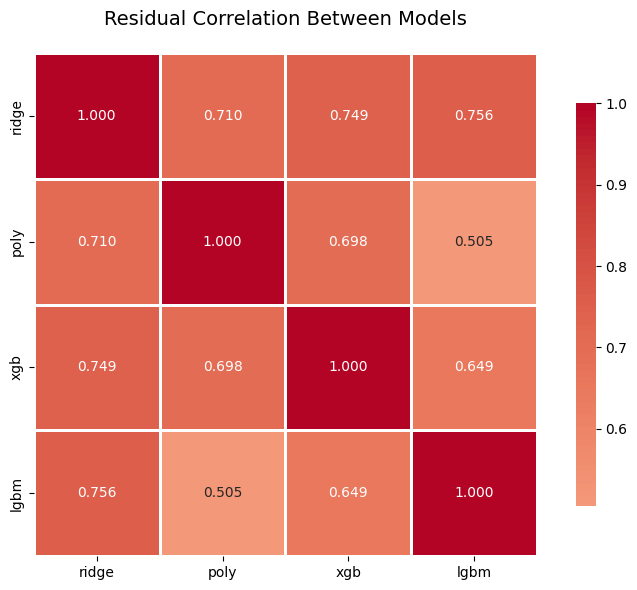


✅ Done!


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ========== CALCULATE RESIDUALS ==========
residuals = pd.DataFrame({
    "ridge": y_val.values - y_val_pred_ridge,
    "poly": y_val.values - y_val_poly,
    "xgb": y_val.values - y_val_pred_xg,
    "lgbm": y_val.values - y_val_pred_lgbm
})

# ========== CORRELATION ==========
residual_corr = residuals.corr()

print("="*70)
print("RESIDUAL CORRELATION MATRIX")
print("="*70)
print(residual_corr)

# ========== VISUALIZE ==========
plt.figure(figsize=(8, 6))
sns.heatmap(residual_corr, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Residual Correlation Between Models', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('residual_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Done!")

# Ensembled

In [60]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone

def create_stacked_ridge_ensemble(base_models, X_train, y_train, X_val, y_val,
                                   selected_features, optimize_alpha=True, 
                                   alphas=None, n_folds=5, random_state=42):
    """
    Create and optimize a stacked ensemble with Ridge meta-learner using OOF predictions.
    
    Parameters:
    -----------
    base_models : dict
        Dictionary mapping model names to fitted model objects
    X_train, y_train : Training data
    X_val, y_val : Validation data
    selected_features : list
        List of feature names to use
    optimize_alpha : bool
        Whether to use RidgeCV to optimize alpha
    alphas : list or None
        Alpha values to try if optimize_alpha=True
    n_folds : int
        Number of folds for out-of-fold predictions
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    dict containing ensemble and metrics
    """
    
    print("="*70)
    print("STACKED ENSEMBLE WITH RIDGE META-LEARNER")
    print("="*70)
    
    model_names = list(base_models.keys())
    n_models = len(model_names)
    
    if alphas is None:
        alphas = [0.1, 1.0, 10.0, 100.0]
    
    print(f"\nConfiguration:")
    print(f"  Base models: {', '.join(model_names)}")
    print(f"  Number of models: {n_models}")
    print(f"  CV folds: {n_folds}")
    print(f"  Optimize alpha: {optimize_alpha}")
    if optimize_alpha:
        print(f"  Alpha candidates: {alphas}")
    
    # ========================================================================
    # STEP 1: GENERATE OUT-OF-FOLD PREDICTIONS
    # ========================================================================
    print(f"\n{'='*70}")
    print("STEP 1: GENERATING OUT-OF-FOLD PREDICTIONS")
    print(f"{'='*70}")
    
    # Initialize arrays
    oof_predictions = np.zeros((len(X_train), n_models))
    val_predictions = np.zeros((len(X_val), n_models))
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    for model_idx, (model_name, base_model) in enumerate(base_models.items()):
        print(f"\nProcessing {model_name}...")
        
        fold_val_preds = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
            
            # Split data
            X_fold_train = X_train.iloc[train_idx]
            y_fold_train = y_train.iloc[train_idx]
            X_fold_val = X_train.iloc[val_idx]
            
            # Clone and train model
            model_fold = clone(base_model)
            model_fold.fit(X_fold_train, y_fold_train)
            
            # Out-of-fold predictions on training data
            oof_predictions[val_idx, model_idx] = model_fold.predict(X_fold_val)
            
            # Predictions on validation set
            fold_val_preds.append(model_fold.predict(X_val))
            
            print(f"  Fold {fold}/{n_folds} complete", end='\r')
        
        # Average validation predictions across folds
        val_predictions[:, model_idx] = np.mean(fold_val_preds, axis=0)
        
        print(f"  ✅ {model_name} complete" + " "*20)
    
    print(f"\n✅ Out-of-fold predictions generated!")
    print(f"   OOF shape: {oof_predictions.shape}")
    print(f"   Val shape: {val_predictions.shape}")
    
    # ========================================================================
    # STEP 2: TRAIN META-LEARNER
    # ========================================================================
    print(f"\n{'='*70}")
    print("STEP 2: TRAINING RIDGE META-LEARNER")
    print(f"{'='*70}")
    
    if optimize_alpha:
        print(f"\nUsing RidgeCV to optimize alpha...")
        meta_model = RidgeCV(alphas=alphas, cv=5)
        meta_model.fit(oof_predictions, y_train)
        best_alpha = meta_model.alpha_
        print(f"  ✅ Best alpha found: {best_alpha:.4f}")
    else:
        best_alpha = alphas[0] if isinstance(alphas, list) else 1.0
        print(f"\nUsing fixed alpha: {best_alpha}")
        meta_model = Ridge(alpha=best_alpha)
        meta_model.fit(oof_predictions, y_train)
    
    print(f"\n✅ Meta-learner trained!")
    
    # Print coefficients
    print(f"\nMeta-learner coefficients:")
    for name, coef in zip(model_names, meta_model.coef_):
        print(f"  {name:15s}: {coef:8.4f}")
    print(f"  {'Intercept':15s}: {meta_model.intercept_:8.4f}")
    
    # ========================================================================
    # STEP 3: MAKE PREDICTIONS
    # ========================================================================
    print(f"\n{'='*70}")
    print("STEP 3: MAKING PREDICTIONS")
    print(f"{'='*70}")
    
    y_train_pred = meta_model.predict(oof_predictions)
    y_val_pred = meta_model.predict(val_predictions)
    
    print("  ✅ Predictions generated")
    
    # ========================================================================
    # STEP 4: EVALUATE PERFORMANCE
    # ========================================================================
    print(f"\n{'='*70}")
    print("STEP 4: EVALUATING PERFORMANCE")
    print(f"{'='*70}")
    
    # Training metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = np.mean(np.abs(y_train - y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Validation metrics
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = np.mean(np.abs(y_val - y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Overfitting metrics
    rmse_gap = val_rmse - train_rmse
    r2_gap = train_r2 - val_r2
    
    print(f"\nTraining Performance:")
    print(f"  RMSE: {train_rmse:.4f}")
    print(f"  MAE:  {train_mae:.4f}")
    print(f"  R²:   {train_r2:.4f}")
    
    print(f"\nValidation Performance:")
    print(f"  RMSE: {val_rmse:.4f}")
    print(f"  MAE:  {val_mae:.4f}")
    print(f"  R²:   {val_r2:.4f}")
    
    print(f"\nOverfitting Check:")
    print(f"  RMSE gap: {rmse_gap:.4f} ({(rmse_gap/train_rmse)*100:.2f}%)")
    print(f"  R² gap:   {r2_gap:.4f}")
    
    if rmse_gap/train_rmse < 0.1:
        print("  ✅ Low overfitting - model generalizes well")
    elif rmse_gap/train_rmse < 0.2:
        print("  ⚠️  Moderate overfitting")
    else:
        print("  ❌ High overfitting - consider regularization")
    
    # ========================================================================
    # STEP 5: COMPARE TO INDIVIDUAL MODELS
    # ========================================================================
    print(f"\n{'='*70}")
    print("STEP 5: COMPARISON TO BASE MODELS")
    print(f"{'='*70}")
    
    print("\nIndividual model performance on validation set:")
    individual_rmse = {}
    for name, model in base_models.items():
        y_val_individual = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_val_individual))
        individual_rmse[name] = rmse
        print(f"  {name:15s}: {rmse:.4f}")
    
    best_individual = min(individual_rmse.values())
    improvement = ((best_individual - val_rmse) / best_individual) * 100
    
    print(f"\nStacked ensemble:    {val_rmse:.4f}")
    print(f"Best individual:     {best_individual:.4f}")
    print(f"Improvement:         {improvement:.2f}%")
    
    # ========================================================================
    # STEP 6: CREATE ENSEMBLE OBJECT
    # ========================================================================
    print(f"\n{'='*70}")
    print("STEP 6: CREATING ENSEMBLE OBJECT")
    print(f"{'='*70}")
    
    class StackedEnsemble:
        """
        Stacked ensemble predictor using Ridge meta-learner.
        """
        def __init__(self, base_models, meta_model, model_names):
            self.base_models = base_models  # Store as dict
            self.meta_model = meta_model
            self.model_names = model_names
        
        def predict(self, X):
            """Make predictions on new data"""
            # Get base model predictions
            base_preds = np.column_stack([
                self.base_models[name].predict(X)
                for name in self.model_names
            ])
            
            # Meta-learner combines them
            return self.meta_model.predict(base_preds)
        
        def get_coefficients(self):
            """Return meta-learner coefficients"""
            return dict(zip(self.model_names, self.meta_model.coef_))
    
    ensemble = StackedEnsemble(base_models, meta_model, model_names)
    
    # Verify it works (with tolerance for floating point differences)
    test_pred = ensemble.predict(X_val)
    
    # Check if predictions are close (within tolerance)
    if not np.allclose(test_pred, y_val_pred, rtol=1e-5, atol=1e-8):
        print(f"\n⚠️  Warning: Small mismatch in predictions")
        print(f"  Max difference: {np.max(np.abs(test_pred - y_val_pred)):.6f}")
        print(f"  This is likely due to floating point precision and is OK")
    else:
        print("  ✅ Ensemble object created and verified")
    
    # ========================================================================
    # SUMMARY
    # ========================================================================
    print(f"\n{'='*70}")
    print("✅ STACKED ENSEMBLE CREATION COMPLETE")
    print(f"{'='*70}")
    
    return {
        'ensemble': ensemble,
        'meta_model': meta_model,
        'base_models': base_models,
        'model_names': model_names,
        'coefficients': dict(zip(model_names, meta_model.coef_)),
        'intercept': meta_model.intercept_,
        'best_alpha': best_alpha,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'val_r2': val_r2,
        'rmse_gap': rmse_gap,
        'r2_gap': r2_gap,
        'improvement_pct': improvement,
        'individual_rmse': individual_rmse,
        'y_train_pred': y_train_pred,
        'y_val_pred': y_val_pred,
        'oof_predictions': oof_predictions,
        'val_predictions': val_predictions
    }

# Testing and logging different models

In [80]:

base_models = {
    'poly': best_poly_ridge,      # Your polynomial Ridge model
    'lgbm': best_lgbm,          # Your LightGBM model
    'xgb': best_XG_model             # Your XGBoost model (optional)
}
# ========== STEP 2: CREATE STACKED ENSEMBLE ==========
result = create_stacked_ridge_ensemble(
    base_models=base_models,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    selected_features=selected_features,
    optimize_alpha=True,                    # Automatically find best alpha
    alphas=[0.1, 1.0, 10.0, 100.0],        # Alpha values to try
    n_folds=5,                              # Number of CV folds
    random_state=42
)

# ========== STEP 3: ACCESS RESULTS ==========
stacked_ensemble = result['ensemble']
val_rmse = result['val_rmse']
val_r2 = result['val_r2']
coefficients = result['coefficients']

print(f"\nFinal Performance:")
print(f"  Validation RMSE: {val_rmse:.4f}")
print(f"  Validation R²: {val_r2:.4f}")

# ========== STEP 4: USE THE ENSEMBLE ==========
# Make predictions on new data
predictions = stacked_ensemble.predict(X_test)

STACKED ENSEMBLE WITH RIDGE META-LEARNER

Configuration:
  Base models: poly, lgbm, xgb
  Number of models: 3
  CV folds: 5
  Optimize alpha: True
  Alpha candidates: [0.1, 1.0, 10.0, 100.0]

STEP 1: GENERATING OUT-OF-FOLD PREDICTIONS

Processing poly...
  ✅ poly complete                    

Processing lgbm...


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  ✅ lgbm complete                    

Processing xgb...
  ✅ xgb complete                    

✅ Out-of-fold predictions generated!
   OOF shape: (3292, 3)
   Val shape: (2689, 3)

STEP 2: TRAINING RIDGE META-LEARNER

Using RidgeCV to optimize alpha...
  ✅ Best alpha found: 100.0000

✅ Meta-learner trained!

Meta-learner coefficients:
  poly           :   0.3404
  lgbm           :  -0.1035
  xgb            :   0.5809
  Intercept      : 121.5069

STEP 3: MAKING PREDICTIONS
  ✅ Predictions generated

STEP 4: EVALUATING PERFORMANCE

Training Performance:
  RMSE: 2111.4992
  MAE:  566.4222
  R²:   0.6162

Validation Performance:
  RMSE: 1260.9640
  MAE:  462.3816
  R²:   0.7694

Overfitting Check:
  RMSE gap: -850.5351 (-40.28%)
  R² gap:   -0.1532
  ✅ Low overfitting - model generalizes well

STEP 5: COMPARISON TO BASE MODELS

Individual model performance on validation set:
  poly           : 1350.6125
  lgbm           : 1431.0001
  xgb            : 1247.8709

Stacked ensemble:    1260.96

/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [81]:
# ========================================================================
# LOG STACKED ENSEMBLE TO MLFLOW (Poly + LightGBM + XGBoost)
# ========================================================================

mlflow.set_experiment("Ensemble_Models_CLV")

with mlflow.start_run(run_name="Stacked_Poly_LightGBM_XGBoost"):
    
    print("\n" + "="*70)
    print("LOGGING STACKED ENSEMBLE TO MLFLOW")
    print("="*70)
    
    # ====================================================================
    # 1. LOG PARAMETERS
    # ====================================================================
    print("\n1. Logging parameters...")
    
    mlflow.log_params({
        "ensemble_type": "stacked",
        "meta_learner": "ridge",
        "n_base_models": len(result['model_names']),
        "base_models": ",".join(result['model_names']),
        "n_folds": 5,
        "best_alpha": result['best_alpha'],
        "optimize_alpha": True,
        "random_state": 42
    })
    
    # Log meta-learner coefficients
    for name, coef in result['coefficients'].items():
        mlflow.log_param(f"meta_coef_{name}", round(coef, 4))
    mlflow.log_param("meta_intercept", round(result['intercept'], 4))
    
    print("  ✅ Parameters logged")
    
    # ====================================================================
    # 2. LOG METRICS
    # ====================================================================
    print("\n2. Logging metrics...")
    
    mlflow.log_metrics({
        # Training metrics
        "train_rmse": result['train_rmse'],
        "train_mae": result['train_mae'],
        "train_r2": result['train_r2'],
        
        # Validation metrics
        "val_rmse": result['val_rmse'],
        "val_mae": result['val_mae'],
        "val_r2": result['val_r2'],
        
        # Overfitting metrics
        "rmse_gap": result['rmse_gap'],
        "r2_gap": result['r2_gap'],
        
        # Improvement
        "improvement_pct": result['improvement_pct']
    })
    
    # Log individual base model performance
    for name, rmse in result['individual_rmse'].items():
        mlflow.log_metric(f"{name}_val_rmse", rmse)
    
    print("  ✅ Metrics logged")
    
    # ====================================================================
    # 3. LOG MODELS
    # ====================================================================
    print("\n3. Logging models...")
    
    # Log meta-learner only (this is the key component)
    mlflow.sklearn.log_model(result['meta_model'], "meta_learner")
    
    # Save base model names and instructions for reconstruction
    reconstruction_info = {
        "base_models": result['model_names'],
        "instructions": "To reconstruct ensemble: get base model predictions, then use meta_learner.predict(base_predictions)",
        "meta_learner_artifact": "meta_learner"
    }
    
    with open('ensemble_reconstruction_poly_lgbm_xgb.json', 'w') as f:
        json.dump(reconstruction_info, f, indent=2)
    mlflow.log_artifact('ensemble_reconstruction_poly_lgbm_xgb.json')
    
    print("  ✅ Models logged (meta-learner + reconstruction info)")
    
    # ====================================================================
    # 4. LOG CONFIGURATION FILES
    # ====================================================================
    print("\n4. Logging configuration...")
    
    # Meta-learner config
    mlflow.log_dict({
        "coefficients": {k: float(v) for k, v in result['coefficients'].items()},
        "intercept": float(result['intercept']),
        "best_alpha": float(result['best_alpha']),
        "base_models": result['model_names']
    }, "meta_learner_config.json")
    
    # Performance summary
    mlflow.log_dict({
        "train": {
            "rmse": float(result['train_rmse']),
            "mae": float(result['train_mae']),
            "r2": float(result['train_r2'])
        },
        "validation": {
            "rmse": float(result['val_rmse']),
            "mae": float(result['val_mae']),
            "r2": float(result['val_r2'])
        },
        "individual_models": {name: float(rmse) 
                             for name, rmse in result['individual_rmse'].items()},
        "improvement_pct": float(result['improvement_pct'])
    }, "performance_summary.json")
    
    print("  ✅ Configuration logged")
    
    # ====================================================================
    # 5. CREATE VISUALIZATIONS
    # ====================================================================
    print("\n5. Creating visualizations...")
    
    # Plot 1: Meta-learner Coefficients
    plt.figure(figsize=(10, 6))
    names = list(result['coefficients'].keys())
    coefs = list(result['coefficients'].values())
    colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in coefs]
    
    bars = plt.bar(names, coefs, color=colors, edgecolor='black', linewidth=1.5)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=11, fontweight='bold')
    
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    plt.ylabel('Coefficient Value', fontsize=12, fontweight='bold')
    plt.title('Stacked Ensemble (Poly + LightGBM + XGBoost) - Ridge Meta-Learner Coefficients', 
              fontsize=13, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('meta_learner_coefficients_poly_lgbm_xgb.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('meta_learner_coefficients_poly_lgbm_xgb.png')
    plt.close()
    
    # Plot 2: Model Comparison
    plt.figure(figsize=(10, 6))
    
    comparison_names = list(result['individual_rmse'].keys()) + ['Stacked']
    comparison_rmse = list(result['individual_rmse'].values()) + [result['val_rmse']]
    
    colors = ['#3498db'] * len(result['individual_rmse']) + ['#2ecc71']
    bars = plt.bar(comparison_names, comparison_rmse, color=colors, 
                  edgecolor='black', linewidth=1.5)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.ylabel('Validation RMSE', fontsize=12, fontweight='bold')
    plt.title('Model Performance Comparison (Poly + LightGBM + XGBoost Stacked)', 
              fontsize=13, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('model_comparison_poly_lgbm_xgb.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('model_comparison_poly_lgbm_xgb.png')
    plt.close()
    
    # Plot 3: Predicted vs Actual
    plt.figure(figsize=(10, 8))
    plt.scatter(y_val, result['y_val_pred'], alpha=0.5, s=30)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
            'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual CLV', fontsize=12, fontweight='bold')
    plt.ylabel('Predicted CLV', fontsize=12, fontweight='bold')
    plt.title('Stacked Ensemble (Poly + LightGBM + XGBoost): Predicted vs Actual', 
              fontsize=13, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('pred_vs_actual_poly_lgbm_xgb.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('pred_vs_actual_poly_lgbm_xgb.png')
    plt.close()
    
    # Plot 4: Residuals
    residuals = y_val - result['y_val_pred']
    plt.figure(figsize=(10, 6))
    plt.scatter(result['y_val_pred'], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel('Predicted CLV', fontsize=12, fontweight='bold')
    plt.ylabel('Residuals', fontsize=12, fontweight='bold')
    plt.title('Stacked Ensemble (Poly + LightGBM + XGBoost): Residual Plot', 
              fontsize=13, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('residuals_poly_lgbm_xgb.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('residuals_poly_lgbm_xgb.png')
    plt.close()
    
    print("  ✅ Visualizations created")
    
    # ====================================================================
    # 6. SET TAGS
    # ====================================================================
    print("\n6. Setting tags...")
    
    mlflow.set_tags({
        "stage": "ensemble",
        "ensemble_type": "stacked",
        "meta_learner": "ridge",
        "n_models": "3",
        "model_combination": "poly_lgbm_xgb",
        "author": "Bread",
        "production_ready": "true"
    })
    
    print("  ✅ Tags set")
    
    # ====================================================================
    # GET RUN INFO
    # ====================================================================
    run_id = mlflow.active_run().info.run_id
    
    print("\n" + "="*70)
    print("✅ SUCCESSFULLY LOGGED TO MLFLOW")
    print("="*70)
    print(f"\nRun ID: {run_id}")
    print(f"Experiment: 4_Ensemble_Models")
    print(f"\nConfiguration:")
    print(f"  Base models: {', '.join(result['model_names'])}")
    print(f"\nPerformance:")
    print(f"  Validation RMSE: {result['val_rmse']:.4f}")
    print(f"  Validation R²:   {result['val_r2']:.4f}")
    print(f"  Improvement:     {result['improvement_pct']:.2f}%")
    print(f"\nMeta-learner Coefficients:")
    for name, coef in result['coefficients'].items():
        print(f"  {name}: {coef:.4f}")
    print(f"\nView at: http://localhost:5000")
    print("="*70)

print("\n🎉 Poly + LightGBM + XGBoost Stacked ensemble logged to MLflow successfully!")

2025/12/16 17:44:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



LOGGING STACKED ENSEMBLE TO MLFLOW

1. Logging parameters...
  ✅ Parameters logged

2. Logging metrics...
  ✅ Metrics logged

3. Logging models...
  ✅ Models logged (meta-learner + reconstruction info)

4. Logging configuration...
  ✅ Configuration logged

5. Creating visualizations...
  ✅ Visualizations created

6. Setting tags...
  ✅ Tags set

✅ SUCCESSFULLY LOGGED TO MLFLOW

Run ID: 944d67912ca343659120e963f0969e04
Experiment: 4_Ensemble_Models

Configuration:
  Base models: poly, lgbm, xgb

Performance:
  Validation RMSE: 1260.9640
  Validation R²:   0.7694
  Improvement:     -1.05%

Meta-learner Coefficients:
  poly: 0.3404
  lgbm: -0.1035
  xgb: 0.5809

View at: http://localhost:5000

🎉 Poly + LightGBM + XGBoost Stacked ensemble logged to MLflow successfully!


# Testing LightGBM and XGBoost

In [94]:
base_models = {
    # 'poly': best_poly_ridge,      # Your polynomial Ridge model
    'lgbm': best_lgbm,          # Your LightGBM model
    'xgb': best_XG_model             # Your XGBoost model (optional)
}

# ========== STEP 2: CREATE STACKED ENSEMBLE ==========
result = create_stacked_ridge_ensemble(
    base_models=base_models,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    selected_features=selected_features,
    optimize_alpha=True,                    # Automatically find best alpha
    alphas=[0.1, 1.0, 10.0, 100.0],        # Alpha values to try
    n_folds=5,                              # Number of CV folds
    random_state=42
)

# ========== STEP 3: ACCESS RESULTS ==========
stacked_ensemble = result['ensemble']
val_rmse = result['val_rmse']
val_r2 = result['val_r2']
coefficients = result['coefficients']

print(f"\nFinal Performance:")
print(f"  Validation RMSE: {val_rmse:.4f}")
print(f"  Validation R²: {val_r2:.4f}")

# ========== STEP 4: USE THE ENSEMBLE ==========
# Make predictions on new data
predictions = stacked_ensemble.predict(X_test)

STACKED ENSEMBLE WITH RIDGE META-LEARNER

Configuration:
  Base models: lgbm, xgb
  Number of models: 2
  CV folds: 5
  Optimize alpha: True
  Alpha candidates: [0.1, 1.0, 10.0, 100.0]

STEP 1: GENERATING OUT-OF-FOLD PREDICTIONS

Processing lgbm...


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  ✅ lgbm complete                    

Processing xgb...
  ✅ xgb complete                    

✅ Out-of-fold predictions generated!
   OOF shape: (3292, 2)
   Val shape: (2689, 2)

STEP 2: TRAINING RIDGE META-LEARNER

Using RidgeCV to optimize alpha...
  ✅ Best alpha found: 100.0000

✅ Meta-learner trained!

Meta-learner coefficients:
  lgbm           :  -0.1617
  xgb            :   1.1986
  Intercept      :   0.1132

STEP 3: MAKING PREDICTIONS
  ✅ Predictions generated

STEP 4: EVALUATING PERFORMANCE

Training Performance:
  RMSE: 2414.5728
  MAE:  579.5217
  R²:   0.4981

Validation Performance:
  RMSE: 1134.8718
  MAE:  424.2123
  R²:   0.8132

Overfitting Check:
  RMSE gap: -1279.7011 (-53.00%)
  R² gap:   -0.3151
  ✅ Low overfitting - model generalizes well

STEP 5: COMPARISON TO BASE MODELS

Individual model performance on validation set:
  lgbm           : 1431.0001
  xgb            : 1247.8709

Stacked ensemble:    1134.8718
Best individual:     1247.8709
Improvement:         9

/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


STACKED ENSEMBLE RESIDUAL ANALYSIS

Model: LightGBM + XGBoost Stacked
Validation RMSE: $1134.87
Validation R²:   0.8132

Error Metrics:
  MAE (Mean Absolute Error):     $424.21
  Median Absolute Error:         $232.93
  Max Error:                     $21257.09
  Min Error:                     $0.06

Error Distribution:
  50th percentile error: $232.93
  75th percentile error: $372.78
  90th percentile error: $747.25
  95th percentile error: $1159.51
  99th percentile error: $3349.35

Prediction Accuracy:
  Within $500: 82.6%
  Within $1000: 93.6%
  Within $2000: 97.9%
  Within $5000: 99.4%

OUTLIER ANALYSIS (errors > $5000)

Total validation customers: 2689
Outliers: 16 (0.6%)

Outlier Statistics:
  Mean actual CLV:    $24832.85
  Mean predicted CLV: $17405.05
  Mean error:         $11680.48

Top 10 Worst Predictions:
  Actual    Predicted         Error    Abs_Error
65642.82 44385.732565  21257.087435 21257.087435
35586.27 15597.213150  19989.056850 19989.056850
19364.16  1435.609059  

/var/folders/h1/xtgd4chd60bc0cqmrmntjd180000gn/T/ipykernel_6472/3726526694.py:164: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('bin')['abs_error'].mean()


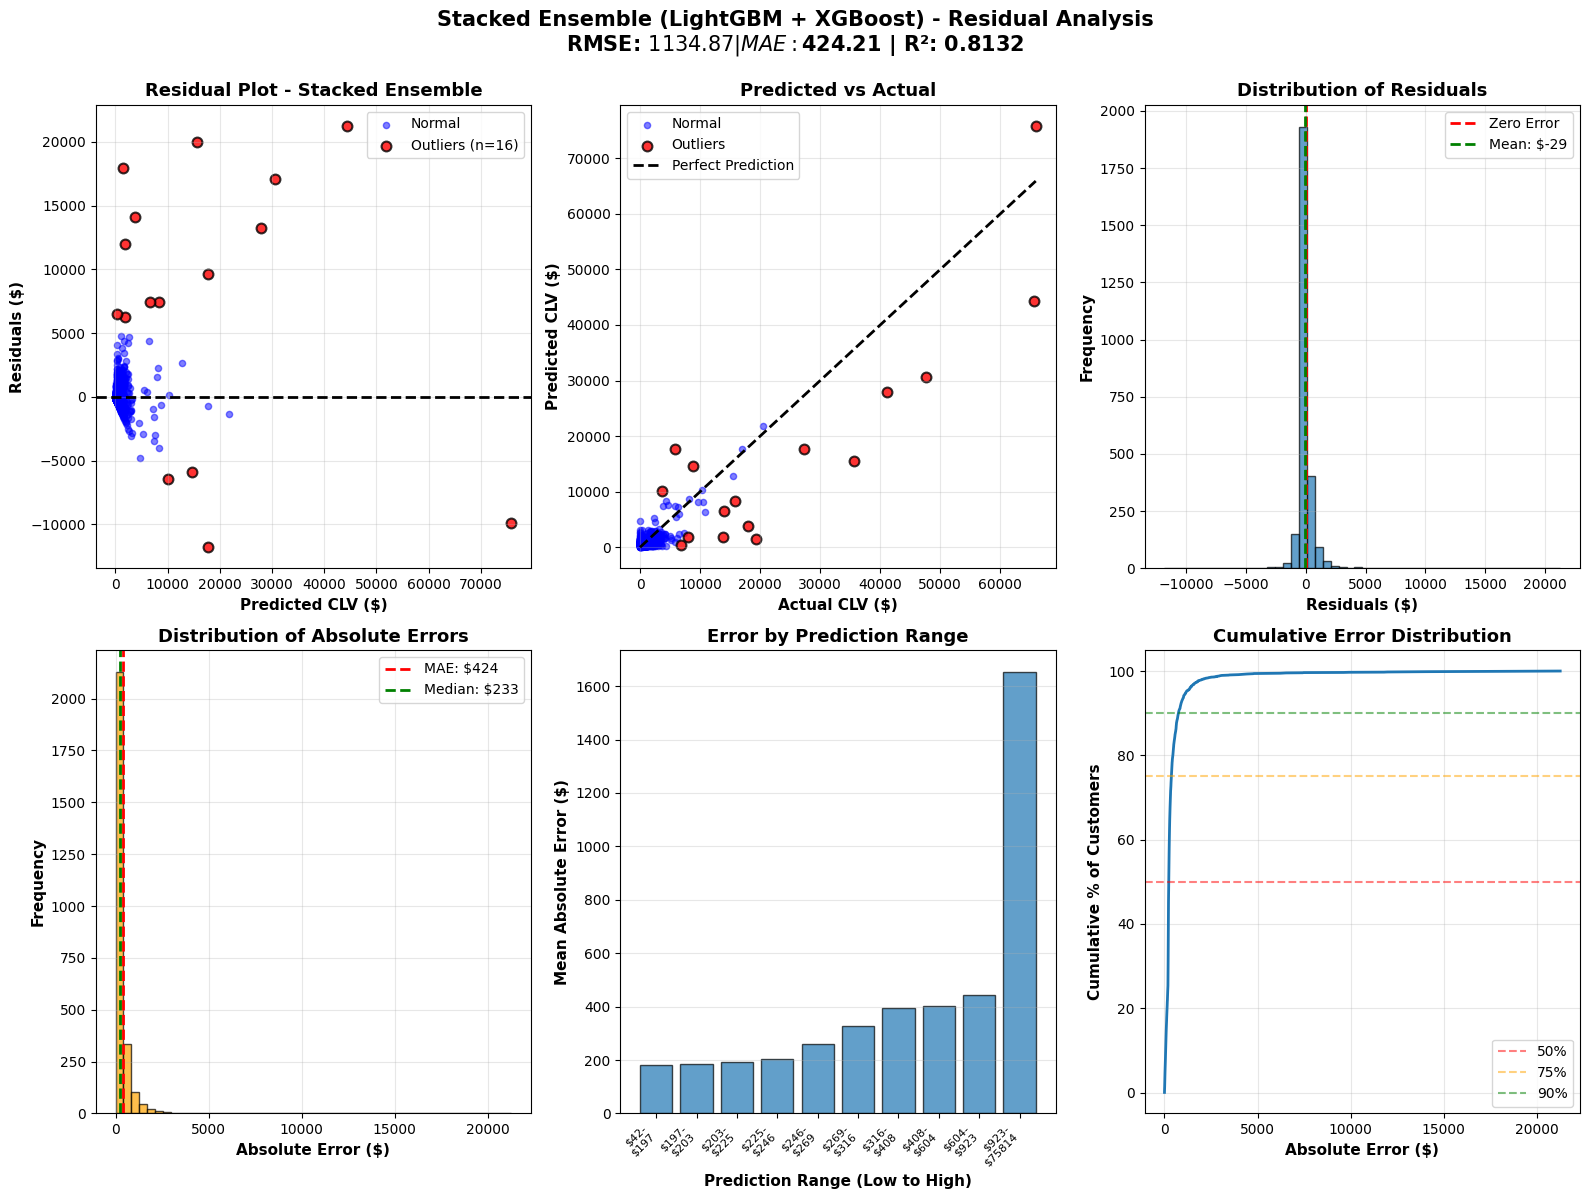


✅ Residual analysis complete!
✅ Saved plot to 'stacked_ensemble_residual_analysis.png'

COMPARISON: STACKED vs BASE MODELS

           Model        RMSE        MAE       R²
Stacked Ensemble 1134.871757 424.212344 0.813242
         XGBoost 1247.870944 424.980492 0.774199
        LightGBM 1431.000078 474.235206 0.703062

🏆 BEST MODEL: Stacked Ensemble
   RMSE: $1134.87
   MAE:  $424.21
   R²:   0.8132


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ========================================================================
# RESIDUAL ANALYSIS FOR STACKED ENSEMBLE
# ========================================================================

# Get predictions from your stacked ensemble
y_val_pred = result['y_val_pred']

# Calculate residuals
residuals = y_val - y_val_pred
abs_residuals = np.abs(residuals)

# ========================================================================
# CALCULATE METRICS
# ========================================================================

print("="*70)
print("STACKED ENSEMBLE RESIDUAL ANALYSIS")
print("="*70)

print(f"\nModel: LightGBM + XGBoost Stacked")
print(f"Validation RMSE: ${val_rmse:.2f}")
print(f"Validation R²:   {val_r2:.4f}")

# Additional metrics
mae = mean_absolute_error(y_val, y_val_pred)
median_ae = np.median(abs_residuals)

print(f"\nError Metrics:")
print(f"  MAE (Mean Absolute Error):     ${mae:.2f}")
print(f"  Median Absolute Error:         ${median_ae:.2f}")
print(f"  Max Error:                     ${abs_residuals.max():.2f}")
print(f"  Min Error:                     ${abs_residuals.min():.2f}")

# Error distribution
print(f"\nError Distribution:")
for pct in [50, 75, 90, 95, 99]:
    val = np.percentile(abs_residuals, pct)
    print(f"  {pct}th percentile error: ${val:.2f}")

print(f"\nPrediction Accuracy:")
for threshold in [500, 1000, 2000, 5000]:
    pct = (abs_residuals <= threshold).sum() / len(abs_residuals) * 100
    print(f"  Within ${threshold}: {pct:.1f}%")

# ========================================================================
# IDENTIFY OUTLIERS
# ========================================================================

# Define outliers as errors > $5000 (adjust as needed)
outlier_threshold = 5000
outliers = abs_residuals > outlier_threshold

print(f"\n" + "="*70)
print(f"OUTLIER ANALYSIS (errors > ${outlier_threshold})")
print("="*70)

print(f"\nTotal validation customers: {len(y_val)}")
print(f"Outliers: {outliers.sum()} ({outliers.sum()/len(y_val)*100:.1f}%)")

if outliers.sum() > 0:
    print(f"\nOutlier Statistics:")
    print(f"  Mean actual CLV:    ${y_val[outliers].mean():.2f}")
    print(f"  Mean predicted CLV: ${y_val_pred[outliers].mean():.2f}")
    print(f"  Mean error:         ${abs_residuals[outliers].mean():.2f}")
    
    # Show worst predictions
    worst_predictions = pd.DataFrame({
        'Actual': y_val[outliers].values,
        'Predicted': y_val_pred[outliers],
        'Error': residuals[outliers].values,
        'Abs_Error': abs_residuals[outliers].values
    }).nlargest(10, 'Abs_Error')
    
    print(f"\nTop 10 Worst Predictions:")
    print(worst_predictions.to_string(index=False))

# Normal customers (non-outliers)
normal = ~outliers
print(f"\n" + "="*70)
print(f"NORMAL CUSTOMERS (errors ≤ ${outlier_threshold})")
print("="*70)

print(f"\nCount: {normal.sum()} ({normal.sum()/len(y_val)*100:.1f}%)")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_val[normal], y_val_pred[normal])):.2f}")
print(f"  MAE:  ${mean_absolute_error(y_val[normal], y_val_pred[normal]):.2f}")
print(f"  R²:   {r2_score(y_val[normal], y_val_pred[normal]):.4f}")

# ========================================================================
# CREATE COMPREHENSIVE RESIDUAL PLOTS
# ========================================================================

fig = plt.figure(figsize=(16, 12))

# ========== PLOT 1: Main Residual Plot ==========
ax1 = plt.subplot(2, 3, 1)
ax1.scatter(y_val_pred[normal], residuals[normal], 
           alpha=0.5, s=20, color='blue', label='Normal')
if outliers.sum() > 0:
    ax1.scatter(y_val_pred[outliers], residuals[outliers], 
               alpha=0.8, s=50, color='red', edgecolor='black', 
               linewidth=1.5, label=f'Outliers (n={outliers.sum()})')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=2)
ax1.set_xlabel('Predicted CLV ($)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Residuals ($)', fontsize=11, fontweight='bold')
ax1.set_title('Residual Plot - Stacked Ensemble', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# ========== PLOT 2: Predicted vs Actual ==========
ax2 = plt.subplot(2, 3, 2)
ax2.scatter(y_val[normal], y_val_pred[normal], 
           alpha=0.5, s=20, color='blue', label='Normal')
if outliers.sum() > 0:
    ax2.scatter(y_val[outliers], y_val_pred[outliers], 
               alpha=0.8, s=50, color='red', edgecolor='black', 
               linewidth=1.5, label='Outliers')
ax2.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
        'k--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual CLV ($)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Predicted CLV ($)', fontsize=11, fontweight='bold')
ax2.set_title('Predicted vs Actual', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# ========== PLOT 3: Residual Distribution ==========
ax3 = plt.subplot(2, 3, 3)
ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax3.axvline(x=residuals.mean(), color='green', linestyle='--', 
           linewidth=2, label=f'Mean: ${residuals.mean():.0f}')
ax3.set_xlabel('Residuals ($)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax3.set_title('Distribution of Residuals', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# ========== PLOT 4: Absolute Error Distribution ==========
ax4 = plt.subplot(2, 3, 4)
ax4.hist(abs_residuals, bins=50, edgecolor='black', alpha=0.7, color='orange')
ax4.axvline(x=mae, color='red', linestyle='--', linewidth=2, 
           label=f'MAE: ${mae:.0f}')
ax4.axvline(x=median_ae, color='green', linestyle='--', linewidth=2, 
           label=f'Median: ${median_ae:.0f}')
ax4.set_xlabel('Absolute Error ($)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title('Distribution of Absolute Errors', fontsize=13, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# ========== PLOT 5: Error by Prediction Range ==========
ax5 = plt.subplot(2, 3, 5)

# Bin predictions
bins = pd.qcut(y_val_pred, q=10, duplicates='drop')
error_by_bin = pd.DataFrame({
    'pred': y_val_pred,
    'abs_error': abs_residuals,
    'bin': bins
}).groupby('bin')['abs_error'].mean()

bin_centers = [interval.mid for interval in error_by_bin.index]
ax5.bar(range(len(error_by_bin)), error_by_bin.values, 
       edgecolor='black', alpha=0.7)
ax5.set_xlabel('Prediction Range (Low to High)', fontsize=11, fontweight='bold')
ax5.set_ylabel('Mean Absolute Error ($)', fontsize=11, fontweight='bold')
ax5.set_title('Error by Prediction Range', fontsize=13, fontweight='bold')
ax5.set_xticks(range(len(error_by_bin)))
ax5.set_xticklabels([f'${interval.left:.0f}-\n${interval.right:.0f}' 
                     for interval in error_by_bin.index], 
                    rotation=45, ha='right', fontsize=8)
ax5.grid(alpha=0.3, axis='y')

# ========== PLOT 6: Cumulative Error Distribution ==========
ax6 = plt.subplot(2, 3, 6)

sorted_errors = np.sort(abs_residuals)
cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100

ax6.plot(sorted_errors, cumulative, linewidth=2)
ax6.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50%')
ax6.axhline(y=75, color='orange', linestyle='--', alpha=0.5, label='75%')
ax6.axhline(y=90, color='green', linestyle='--', alpha=0.5, label='90%')
ax6.set_xlabel('Absolute Error ($)', fontsize=11, fontweight='bold')
ax6.set_ylabel('Cumulative % of Customers', fontsize=11, fontweight='bold')
ax6.set_title('Cumulative Error Distribution', fontsize=13, fontweight='bold')
ax6.legend()
ax6.grid(alpha=0.3)

plt.suptitle(f'Stacked Ensemble (LightGBM + XGBoost) - Residual Analysis\n'
             f'RMSE: ${val_rmse:.2f} | MAE: ${mae:.2f} | R²: {val_r2:.4f}', 
             fontsize=15, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('stacked_ensemble_residual_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("✅ Residual analysis complete!")
print("✅ Saved plot to 'stacked_ensemble_residual_analysis.png'")
print("="*70)

# ========================================================================
# COMPARISON WITH BASE MODELS
# ========================================================================

print("\n" + "="*70)
print("COMPARISON: STACKED vs BASE MODELS")
print("="*70)

# Get predictions from base models
y_val_lgbm = best_lgbm.predict(X_val)
y_val_xgb = best_XG_model.predict(X_val)

# Calculate metrics
models_comparison = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'Stacked Ensemble'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_val, y_val_lgbm)),
        np.sqrt(mean_squared_error(y_val, y_val_xgb)),
        val_rmse
    ],
    'MAE': [
        mean_absolute_error(y_val, y_val_lgbm),
        mean_absolute_error(y_val, y_val_xgb),
        mae
    ],
    'R²': [
        r2_score(y_val, y_val_lgbm),
        r2_score(y_val, y_val_xgb),
        val_r2
    ]
})

models_comparison = models_comparison.sort_values('RMSE')
print("\n" + models_comparison.to_string(index=False))

best_model = models_comparison.iloc[0]
print(f"\n🏆 BEST MODEL: {best_model['Model']}")
print(f"   RMSE: ${best_model['RMSE']:.2f}")
print(f"   MAE:  ${best_model['MAE']:.2f}")
print(f"   R²:   {best_model['R²']:.4f}")

print("="*70)

In [83]:
# ========================================================================
# LOG STACKED ENSEMBLE TO MLFLOW (LightGBM + XGBoost)
# ========================================================================

mlflow.set_experiment("Ensemble_Models_CLV")

with mlflow.start_run(run_name="Stacked_LightGBM_XGBoost"):
    
    print("\n" + "="*70)
    print("LOGGING STACKED ENSEMBLE TO MLFLOW")
    print("="*70)
    
    # ====================================================================
    # 1. LOG PARAMETERS
    # ====================================================================
    print("\n1. Logging parameters...")
    
    mlflow.log_params({
        "ensemble_type": "stacked",
        "meta_learner": "ridge",
        "n_base_models": len(result['model_names']),
        "base_models": ",".join(result['model_names']),
        "n_folds": 5,
        "best_alpha": result['best_alpha'],
        "optimize_alpha": True,
        "random_state": 42
    })
    
    # Log meta-learner coefficients
    for name, coef in result['coefficients'].items():
        mlflow.log_param(f"meta_coef_{name}", round(coef, 4))
    mlflow.log_param("meta_intercept", round(result['intercept'], 4))
    
    print("  ✅ Parameters logged")
    
    # ====================================================================
    # 2. LOG METRICS
    # ====================================================================
    print("\n2. Logging metrics...")
    
    mlflow.log_metrics({
        # Training metrics
        "train_rmse": result['train_rmse'],
        "train_mae": result['train_mae'],
        "train_r2": result['train_r2'],
        
        # Validation metrics
        "val_rmse": result['val_rmse'],
        "val_mae": result['val_mae'],
        "val_r2": result['val_r2'],
        
        # Overfitting metrics
        "rmse_gap": result['rmse_gap'],
        "r2_gap": result['r2_gap'],
        
        # Improvement
        "improvement_pct": result['improvement_pct']
    })
    
    # Log individual base model performance
    for name, rmse in result['individual_rmse'].items():
        mlflow.log_metric(f"{name}_val_rmse", rmse)
    
    print("  ✅ Metrics logged")
    
    # ====================================================================
    # 3. LOG MODELS
    # ====================================================================
    print("\n3. Logging models...")
    
    # Log meta-learner only (this is the key component)
    mlflow.sklearn.log_model(result['meta_model'], "meta_learner")
    
    # Save base model names and instructions for reconstruction
    reconstruction_info = {
        "base_models": result['model_names'],
        "instructions": "To reconstruct ensemble: get base model predictions, then use meta_learner.predict(base_predictions)",
        "meta_learner_artifact": "meta_learner"
    }
    
    with open('ensemble_reconstruction_lgbm_xgb.json', 'w') as f:
        json.dump(reconstruction_info, f, indent=2)
    mlflow.log_artifact('ensemble_reconstruction_lgbm_xgb.json')
    
    print("  ✅ Models logged (meta-learner + reconstruction info)")
    
    # ====================================================================
    # 4. LOG CONFIGURATION FILES
    # ====================================================================
    print("\n4. Logging configuration...")
    
    # Meta-learner config
    mlflow.log_dict({
        "coefficients": {k: float(v) for k, v in result['coefficients'].items()},
        "intercept": float(result['intercept']),
        "best_alpha": float(result['best_alpha']),
        "base_models": result['model_names']
    }, "meta_learner_config.json")
    
    # Performance summary
    mlflow.log_dict({
        "train": {
            "rmse": float(result['train_rmse']),
            "mae": float(result['train_mae']),
            "r2": float(result['train_r2'])
        },
        "validation": {
            "rmse": float(result['val_rmse']),
            "mae": float(result['val_mae']),
            "r2": float(result['val_r2'])
        },
        "individual_models": {name: float(rmse) 
                             for name, rmse in result['individual_rmse'].items()},
        "improvement_pct": float(result['improvement_pct'])
    }, "performance_summary.json")
    
    print("  ✅ Configuration logged")
    
    # ====================================================================
    # 5. CREATE VISUALIZATIONS
    # ====================================================================
    print("\n5. Creating visualizations...")
    
    # Plot 1: Meta-learner Coefficients
    plt.figure(figsize=(10, 6))
    names = list(result['coefficients'].keys())
    coefs = list(result['coefficients'].values())
    colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in coefs]
    
    bars = plt.bar(names, coefs, color=colors, edgecolor='black', linewidth=1.5)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=11, fontweight='bold')
    
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    plt.ylabel('Coefficient Value', fontsize=12, fontweight='bold')
    plt.title('Stacked Ensemble (LightGBM + XGBoost) - Ridge Meta-Learner Coefficients', 
              fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('meta_learner_coefficients_lgbm_xgb.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('meta_learner_coefficients_lgbm_xgb.png')
    plt.close()
    
    # Plot 2: Model Comparison
    plt.figure(figsize=(10, 6))
    
    comparison_names = list(result['individual_rmse'].keys()) + ['Stacked']
    comparison_rmse = list(result['individual_rmse'].values()) + [result['val_rmse']]
    
    colors = ['#3498db'] * len(result['individual_rmse']) + ['#2ecc71']
    bars = plt.bar(comparison_names, comparison_rmse, color=colors, 
                  edgecolor='black', linewidth=1.5)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.ylabel('Validation RMSE', fontsize=12, fontweight='bold')
    plt.title('Model Performance Comparison (LightGBM + XGBoost Stacked)', 
              fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('model_comparison_lgbm_xgb.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('model_comparison_lgbm_xgb.png')
    plt.close()
    
    # Plot 3: Predicted vs Actual
    plt.figure(figsize=(10, 8))
    plt.scatter(y_val, result['y_val_pred'], alpha=0.5, s=30)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
            'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual CLV', fontsize=12, fontweight='bold')
    plt.ylabel('Predicted CLV', fontsize=12, fontweight='bold')
    plt.title('Stacked Ensemble (LightGBM + XGBoost): Predicted vs Actual', 
              fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('pred_vs_actual_lgbm_xgb.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('pred_vs_actual_lgbm_xgb.png')
    plt.close()
    
    # Plot 4: Residuals
    residuals = y_val - result['y_val_pred']
    plt.figure(figsize=(10, 6))
    plt.scatter(result['y_val_pred'], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel('Predicted CLV', fontsize=12, fontweight='bold')
    plt.ylabel('Residuals', fontsize=12, fontweight='bold')
    plt.title('Stacked Ensemble (LightGBM + XGBoost): Residual Plot', 
              fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('residuals_lgbm_xgb.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('residuals_lgbm_xgb.png')
    plt.close()
    
    print("  ✅ Visualizations created")
    
    # ====================================================================
    # 6. SET TAGS
    # ====================================================================
    print("\n6. Setting tags...")
    
    mlflow.set_tags({
        "stage": "ensemble",
        "ensemble_type": "stacked",
        "meta_learner": "ridge",
        "n_models": "2",
        "model_combination": "lgbm_xgb",
        "author": "Bread",
        "production_ready": "true"
    })
    
    print("  ✅ Tags set")
    
    # ====================================================================
    # GET RUN INFO
    # ====================================================================
    run_id = mlflow.active_run().info.run_id
    
    print("\n" + "="*70)
    print("✅ SUCCESSFULLY LOGGED TO MLFLOW")
    print("="*70)
    print(f"\nRun ID: {run_id}")
    print(f"Experiment: 4_Ensemble_Models")
    print(f"\nConfiguration:")
    print(f"  Base models: {', '.join(result['model_names'])}")
    print(f"\nPerformance:")
    print(f"  Validation RMSE: {result['val_rmse']:.4f}")
    print(f"  Validation R²:   {result['val_r2']:.4f}")
    print(f"  Improvement:     {result['improvement_pct']:.2f}%")
    print(f"\nMeta-learner Coefficients:")
    for name, coef in result['coefficients'].items():
        print(f"  {name}: {coef:.4f}")
    print(f"\nView at: http://localhost:5000")
    print("="*70)

print("\n🎉 LightGBM + XGBoost Stacked ensemble logged to MLflow successfully!")

2025/12/16 17:44:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



LOGGING STACKED ENSEMBLE TO MLFLOW

1. Logging parameters...
  ✅ Parameters logged

2. Logging metrics...
  ✅ Metrics logged

3. Logging models...
  ✅ Models logged (meta-learner + reconstruction info)

4. Logging configuration...
  ✅ Configuration logged

5. Creating visualizations...
  ✅ Visualizations created

6. Setting tags...
  ✅ Tags set

✅ SUCCESSFULLY LOGGED TO MLFLOW

Run ID: 6b2ea36dfb324997b7f783a8ecfcdb98
Experiment: 4_Ensemble_Models

Configuration:
  Base models: lgbm, xgb

Performance:
  Validation RMSE: 1134.8718
  Validation R²:   0.8132
  Improvement:     9.06%

Meta-learner Coefficients:
  lgbm: -0.1617
  xgb: 1.1986

View at: http://localhost:5000

🎉 LightGBM + XGBoost Stacked ensemble logged to MLflow successfully!


### Trying Ridge, XG and LGBM

In [84]:
base_models = {
    'Ridge': best_ridge,      # Your polynomial Ridge model
    'lgbm': best_lgbm,          # Your LightGBM model
    'xgb': best_XG_model             # Your XGBoost model (optional)
}

# ========== STEP 2: CREATE STACKED ENSEMBLE ==========
result = create_stacked_ridge_ensemble(
    base_models=base_models,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    selected_features=selected_features,
    optimize_alpha=True,                    # Automatically find best alpha
    alphas=[0.1, 1.0, 10.0, 100.0],        # Alpha values to try
    n_folds=5,                              # Number of CV folds
    random_state=42
)

# ========== STEP 3: ACCESS RESULTS ==========
stacked_ensemble = result['ensemble']
val_rmse = result['val_rmse']
val_r2 = result['val_r2']
coefficients = result['coefficients']

print(f"\nFinal Performance:")
print(f"  Validation RMSE: {val_rmse:.4f}")
print(f"  Validation R²: {val_r2:.4f}")

# ========== STEP 4: USE THE ENSEMBLE ==========
# Make predictions on new data
predictions = stacked_ensemble.predict(X_test)

STACKED ENSEMBLE WITH RIDGE META-LEARNER

Configuration:
  Base models: Ridge, lgbm, xgb
  Number of models: 3
  CV folds: 5
  Optimize alpha: True
  Alpha candidates: [0.1, 1.0, 10.0, 100.0]

STEP 1: GENERATING OUT-OF-FOLD PREDICTIONS

Processing Ridge...
  ✅ Ridge complete                    

Processing lgbm...


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  ✅ lgbm complete                    

Processing xgb...
  ✅ xgb complete                    

✅ Out-of-fold predictions generated!
   OOF shape: (3292, 3)
   Val shape: (2689, 3)

STEP 2: TRAINING RIDGE META-LEARNER

Using RidgeCV to optimize alpha...
  ✅ Best alpha found: 100.0000

✅ Meta-learner trained!

Meta-learner coefficients:
  Ridge          :   1.1460
  lgbm           :  -0.4259
  xgb            :   0.2802
  Intercept      :   7.5653

STEP 3: MAKING PREDICTIONS
  ✅ Predictions generated

STEP 4: EVALUATING PERFORMANCE

Training Performance:
  RMSE: 1905.9433
  MAE:  572.3588
  R²:   0.6873

Validation Performance:
  RMSE: 1226.2392
  MAE:  457.2481
  R²:   0.7820

Overfitting Check:
  RMSE gap: -679.7041 (-35.66%)
  R² gap:   -0.0947
  ✅ Low overfitting - model generalizes well

STEP 5: COMPARISON TO BASE MODELS

Individual model performance on validation set:
  Ridge          : 1269.2618
  lgbm           : 1431.0001
  xgb            : 1247.8709

Stacked ensemble:    1226.23

/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/clv_project/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [85]:
# ========================================================================
# LOG STACKED ENSEMBLE TO MLFLOW (Ridge + LightGBM + XGBoost)
# ========================================================================

mlflow.set_experiment("Ensemble_Models_CLV")

with mlflow.start_run(run_name="Stacked_Ridge_LightGBM_XGBoost"):
    
    print("\n" + "="*70)
    print("LOGGING STACKED ENSEMBLE TO MLFLOW")
    print("="*70)
    
    # ====================================================================
    # 1. LOG PARAMETERS
    # ====================================================================
    print("\n1. Logging parameters...")
    
    mlflow.log_params({
        "ensemble_type": "stacked",
        "meta_learner": "ridge",
        "n_base_models": len(result['model_names']),
        "base_models": ",".join(result['model_names']),
        "n_folds": 5,
        "best_alpha": result['best_alpha'],
        "optimize_alpha": True,
        "random_state": 42
    })
    
    # Log meta-learner coefficients
    for name, coef in result['coefficients'].items():
        mlflow.log_param(f"meta_coef_{name}", round(coef, 4))
    mlflow.log_param("meta_intercept", round(result['intercept'], 4))
    
    print("  ✅ Parameters logged")
    
    # ====================================================================
    # 2. LOG METRICS
    # ====================================================================
    print("\n2. Logging metrics...")
    
    mlflow.log_metrics({
        # Training metrics
        "train_rmse": result['train_rmse'],
        "train_mae": result['train_mae'],
        "train_r2": result['train_r2'],
        
        # Validation metrics
        "val_rmse": result['val_rmse'],
        "val_mae": result['val_mae'],
        "val_r2": result['val_r2'],
        
        # Overfitting metrics
        "rmse_gap": result['rmse_gap'],
        "r2_gap": result['r2_gap'],
        
        # Improvement
        "improvement_pct": result['improvement_pct']
    })
    
    # Log individual base model performance
    for name, rmse in result['individual_rmse'].items():
        mlflow.log_metric(f"{name}_val_rmse", rmse)
    
    print("  ✅ Metrics logged")
    
    # ====================================================================
    # 3. LOG MODELS
    # ====================================================================
    print("\n3. Logging models...")
    
    # Log meta-learner only (this is the key component)
    mlflow.sklearn.log_model(result['meta_model'], "meta_learner")
    
    # Save base model names and instructions for reconstruction
    import json
    reconstruction_info = {
        "base_models": result['model_names'],
        "instructions": "To reconstruct ensemble: get base model predictions, then use meta_learner.predict(base_predictions)",
        "meta_learner_artifact": "meta_learner"
    }
    
    with open('ensemble_reconstruction.json', 'w') as f:
        json.dump(reconstruction_info, f, indent=2)
    mlflow.log_artifact('ensemble_reconstruction.json')
    
    print("  ✅ Models logged (meta-learner + reconstruction info)")
    
    # ====================================================================
    # 4. LOG CONFIGURATION FILES
    # ====================================================================
    print("\n4. Logging configuration...")
    
    # Meta-learner config
    mlflow.log_dict({
        "coefficients": {k: float(v) for k, v in result['coefficients'].items()},
        "intercept": float(result['intercept']),
        "best_alpha": float(result['best_alpha']),
        "base_models": result['model_names']
    }, "meta_learner_config.json")
    
    # Performance summary
    mlflow.log_dict({
        "train": {
            "rmse": float(result['train_rmse']),
            "mae": float(result['train_mae']),
            "r2": float(result['train_r2'])
        },
        "validation": {
            "rmse": float(result['val_rmse']),
            "mae": float(result['val_mae']),
            "r2": float(result['val_r2'])
        },
        "individual_models": {name: float(rmse) 
                             for name, rmse in result['individual_rmse'].items()},
        "improvement_pct": float(result['improvement_pct'])
    }, "performance_summary.json")
    
    print("  ✅ Configuration logged")
    
    # ====================================================================
    # 5. CREATE VISUALIZATIONS
    # ====================================================================
    print("\n5. Creating visualizations...")
    
    # Plot 1: Meta-learner Coefficients
    plt.figure(figsize=(10, 6))
    names = list(result['coefficients'].keys())
    coefs = list(result['coefficients'].values())
    colors = ['#2ecc71' if c > 0 else '#e74c3c' for c in coefs]
    
    bars = plt.bar(names, coefs, color=colors, edgecolor='black', linewidth=1.5)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=11, fontweight='bold')
    
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    plt.ylabel('Coefficient Value', fontsize=12, fontweight='bold')
    plt.title('Stacked Ensemble (3 Models) - Ridge Meta-Learner Coefficients', 
              fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('meta_learner_coefficients_3models.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('meta_learner_coefficients_3models.png')
    plt.close()
    
    # Plot 2: Model Comparison
    plt.figure(figsize=(10, 6))
    
    comparison_names = list(result['individual_rmse'].keys()) + ['Stacked']
    comparison_rmse = list(result['individual_rmse'].values()) + [result['val_rmse']]
    
    colors = ['#3498db'] * len(result['individual_rmse']) + ['#2ecc71']
    bars = plt.bar(comparison_names, comparison_rmse, color=colors, 
                  edgecolor='black', linewidth=1.5)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.0f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.ylabel('Validation RMSE', fontsize=12, fontweight='bold')
    plt.title('Model Performance Comparison (3-Model Stacked)', 
              fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('model_comparison_3models.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('model_comparison_3models.png')
    plt.close()
    
    # Plot 3: Predicted vs Actual
    plt.figure(figsize=(10, 8))
    plt.scatter(y_val, result['y_val_pred'], alpha=0.5, s=30)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
            'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual CLV', fontsize=12, fontweight='bold')
    plt.ylabel('Predicted CLV', fontsize=12, fontweight='bold')
    plt.title('Stacked Ensemble (3 Models): Predicted vs Actual', 
              fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('pred_vs_actual_3models.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('pred_vs_actual_3models.png')
    plt.close()
    
    # Plot 4: Residuals
    residuals = y_val - result['y_val_pred']
    plt.figure(figsize=(10, 6))
    plt.scatter(result['y_val_pred'], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel('Predicted CLV', fontsize=12, fontweight='bold')
    plt.ylabel('Residuals', fontsize=12, fontweight='bold')
    plt.title('Stacked Ensemble (3 Models): Residual Plot', 
              fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('residuals_3models.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('residuals_3models.png')
    plt.close()
    
    print("  ✅ Visualizations created")
    
    # ====================================================================
    # 6. SET TAGS
    # ====================================================================
    print("\n6. Setting tags...")
    
    mlflow.set_tags({
        "stage": "ensemble",
        "ensemble_type": "stacked",
        "meta_learner": "ridge",
        "n_models": "3",
        "author": "Bread",
        "production_ready": "true"
    })
    
    print("  ✅ Tags set")
    
    # ====================================================================
    # GET RUN INFO
    # ====================================================================
    run_id = mlflow.active_run().info.run_id
    
    print("\n" + "="*70)
    print("✅ SUCCESSFULLY LOGGED TO MLFLOW")
    print("="*70)
    print(f"\nRun ID: {run_id}")
    print(f"Experiment: 4_Ensemble_Models")
    print(f"\nConfiguration:")
    print(f"  Base models: {', '.join(result['model_names'])}")
    print(f"\nPerformance:")
    print(f"  Validation RMSE: {result['val_rmse']:.4f}")
    print(f"  Validation R²:   {result['val_r2']:.4f}")
    print(f"  Improvement:     {result['improvement_pct']:.2f}%")
    print(f"\nMeta-learner Coefficients:")
    for name, coef in result['coefficients'].items():
        print(f"  {name}: {coef:.4f}")
    print(f"\nView at: http://localhost:5000")
    print("="*70)

print("\n🎉 3-Model Stacked ensemble logged to MLflow successfully!")

2025/12/16 17:44:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



LOGGING STACKED ENSEMBLE TO MLFLOW

1. Logging parameters...
  ✅ Parameters logged

2. Logging metrics...
  ✅ Metrics logged

3. Logging models...
  ✅ Models logged (meta-learner + reconstruction info)

4. Logging configuration...
  ✅ Configuration logged

5. Creating visualizations...
  ✅ Visualizations created

6. Setting tags...
  ✅ Tags set

✅ SUCCESSFULLY LOGGED TO MLFLOW

Run ID: 17e3ef232fb04e2898254ab80a42a030
Experiment: 4_Ensemble_Models

Configuration:
  Base models: Ridge, lgbm, xgb

Performance:
  Validation RMSE: 1226.2392
  Validation R²:   0.7820
  Improvement:     1.73%

Meta-learner Coefficients:
  Ridge: 1.1460
  lgbm: -0.4259
  xgb: 0.2802

View at: http://localhost:5000

🎉 3-Model Stacked ensemble logged to MLflow successfully!


Repeat but adding these additional features:
    # ADD THESE TIME-BASED FEATURES:
    'days_since_last_purchase',  # ⭐ RECENCY - highly predictive!
    'customer_age_days',          # ⭐ TENURE - loyal customers spend more
    
    # ADD THESE TOO (already in your dataset):
    'avg_item_value',             # Price sensitivity
    'MIN(transactions.Revenue)',   # Baseline behavior
    'MEAN(transactions.Quantity)', # Purchase patterns